In [112]:
import os
from zipfile import ZipFile
import pathlib
from datetime import datetime
from dateutil import parser

import pandas as pd
import numpy as np

import spacy
import spacy_fastlang
from spacy.tokens import DocBin
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

random_seed = 0
np.random.seed(random_seed)

LOAD_TOKENS_FROM_FILE = True
TOKENS_PATH = os.path.join("data", "tokens.bin")

The `sentiment140` dataset contains 1,600,000 tweets extracted using the twitter api.

The tweets have been annotated *(0 = negative, 4 = positive)* and they can be used to detect sentiment.

It contains the following 6 fields:
- `target`: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- `ids`: The id of the tweet ( 2087)
- `date`: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- `flag`: The query (lyx). If there is no query, then this value is NO_QUERY.
- `user`: the user that tweeted (robotickilldozr)
- `text`: the text of the tweet (Lyx is cool)

# Analyse exploratoire du jeu de données

In [2]:
source = pathlib.Path(pathlib.Path().absolute(), 'data', 'sentiment140.zip')

In [3]:
import charset_normalizer
with open(source, 'rb') as rawdata:
    result = charset_normalizer.detect(rawdata.read(1000000))
result

{'encoding': None, 'language': '', 'confidence': None}

In [4]:
# Method 2
df = pd.read_csv(
    source, 
    compression='zip', 
    #encoding='cp1252', 
    encoding = 'latin',
    header=None, 
    names=['target', 'ids', 'date', 'flag', 'user', 'text'],
    #parse_dates=['date'],
    #infer_datetime_format=True,
    #date_parser=parse_tweet_dates,
)

In [5]:
display(df.head(2), df.shape)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1600000, 6)

## Vérifions les types des colonnes

In [6]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
df = df.astype({
    "target": 'category', 
    "ids": 'category',
    #"date": 'datetime64',
    "flag": 'category',
    "user": 'category',
    #"text": 'object',
})

In [8]:
df.dtypes

target    category
ids       category
date        object
flag      category
user      category
text        object
dtype: object

In [9]:
df.head(2)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


## Cherchons les éventuels doublons

#### Vérifions sur l'ensemble des colonnes

In [10]:
df.duplicated().sum()

0

#### A présent, vérifions sans tenir compte de la `target` au cas ou certains doublons auraient les deux valeurs

In [11]:
subset = ['ids', 'date', 'flag', 'user', 'text']
df.duplicated(subset=subset).sum()

1685

In [12]:
df[df.duplicated(keep=False, subset=subset)].sort_values('text').head(10)

,target,ids,date,flag,user,text
1394129,4,2053581479,Sat Jun 06 05:02:55 PDT 2009,NO_QUERY,FunStarLiz,British weather is back i see! Oh well Birtne...
385331,0,2053581479,Sat Jun 06 05:02:55 PDT 2009,NO_QUERY,FunStarLiz,British weather is back i see! Oh well Birtne...
1077756,4,1967735038,Fri May 29 20:07:06 PDT 2009,NO_QUERY,macpoulet67,Raining tomorrow afternoon but its going to b...
184535,0,1967735038,Fri May 29 20:07:06 PDT 2009,NO_QUERY,macpoulet67,Raining tomorrow afternoon but its going to b...
118605,0,1827871029,Sun May 17 11:37:14 PDT 2009,NO_QUERY,mckyliecooper,Uhm.. science! -.- Verrrry boring and LONG G...
968532,4,1827871029,Sun May 17 11:37:14 PDT 2009,NO_QUERY,mckyliecooper,Uhm.. science! -.- Verrrry boring and LONG G...
1443107,4,2062079422,Sat Jun 06 22:17:07 PDT 2009,NO_QUERY,kiarapop,back to maths. i wish i could stab it. but at...
419860,0,2062079422,Sat Jun 06 22:17:07 PDT 2009,NO_QUERY,kiarapop,back to maths. i wish i could stab it. but at...
190549,0,1969383342,Fri May 29 23:51:54 PDT 2009,NO_QUERY,iSelah,but then again
1086997,4,1969383342,Fri May 29 23:51:54 PDT 2009,NO_QUERY,iSelah,but then again


>#### On constate que l'on a 1685 échantillons pour lesquels on a à la fois une target *positive* (4) et une target *negative* (0)...
> comme on ne connait pas la véritable target des ces échantillons en double, il nous faut supprimer les 3370 *(2 x 1685)*

In [13]:
df.drop_duplicates(keep=False, subset=subset, inplace=True)

In [14]:
display(df.head(2), df.shape)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1596630, 6)

In [15]:
df.ids.duplicated().sum()

0

In [16]:
df.ids.describe()

count        1596630
unique       1596630
top       1467810369
freq               1
Name: ids, dtype: int64

#### Enfin, vérifions si l'on a des `textes` qui apparaissent plusieurs fois avec la même `target`

In [17]:
subset= ['text']
df.duplicated(subset=subset).sum()

16836

In [18]:
df[df.duplicated(keep=False, subset=subset)].sort_values('text').head(10)

,target,ids,date,flag,user,text
271505,0,1990029536,Mon Jun 01 03:38:42 PDT 2009,NO_QUERY,Jana1503,David must be hospitalized for five days end...
271472,0,1990023076,Mon Jun 01 03:37:19 PDT 2009,NO_QUERY,Jana1503,David must be hospitalized for five days end...
1132074,4,1975956536,Sat May 30 16:16:11 PDT 2009,NO_QUERY,dstocum,bathroom is clean..... now on to more enjoya...
1132076,4,1975956610,Sat May 30 16:16:11 PDT 2009,NO_QUERY,DavidStocum,bathroom is clean..... now on to more enjoya...
540173,0,2199659424,Tue Jun 16 17:49:15 PDT 2009,NO_QUERY,cutthroatpixie,#IMISSCATH #IMISSCATH #IMISSCATH #IMISSCATH #...
540159,0,2199656747,Tue Jun 16 17:49:00 PDT 2009,NO_QUERY,cutthroatpixie,#IMISSCATH #IMISSCATH #IMISSCATH #IMISSCATH #...
1364947,4,2049859280,Fri Jun 05 17:37:43 PDT 2009,NO_QUERY,MonicaEira,#seb-day #seb-day #seb-day #seb-day #seb-day ...
1357123,4,2047924312,Fri Jun 05 14:23:16 PDT 2009,NO_QUERY,DihDesrosiers,#seb-day #seb-day #seb-day #seb-day #seb-day ...
331063,0,2012536119,Tue Jun 02 20:49:46 PDT 2009,NO_QUERY,iShatara,*tear*
287201,0,1994140773,Mon Jun 01 11:28:38 PDT 2009,NO_QUERY,vanitiiluv,*tear*


>#### On constate que l'on a encore 16836 échantillons dont les textes apparaissent plusieurs fois dans le jeu de données
> il convient donc de n'en garder qu'un seul exemplaire de chaque

In [19]:
df.drop_duplicates(keep='first', subset=subset, inplace=True)

In [20]:
display(df.head(2), df.shape)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1579794, 6)

In [21]:
df.text.describe()

count                                               1579794
unique                                              1579794
top       @switchfoot http://twitpic.com/2y1zl - Awww, t...
freq                                                      1
Name: text, dtype: object

## Analysons la colonne `target`
#### Regardons sa distribution

In [22]:
df.target.value_counts()

4    791281
0    788513
Name: target, dtype: int64

>#### On constate donc que les targets sont équitablement distribuées entre 0 *(negative)* et 4 *(positive)*, mais qu'il n'y a pas de 2 *(neutral)*
> il n'est donc pas nécessaire d'effectuer un ré-équilibrage, mais nous pourrions changer la colonne en bool ou rendre les labels plus clairs.

In [23]:
remap = {0: "negative", 4: "positive"}
df.replace({"target": remap}, inplace=True)

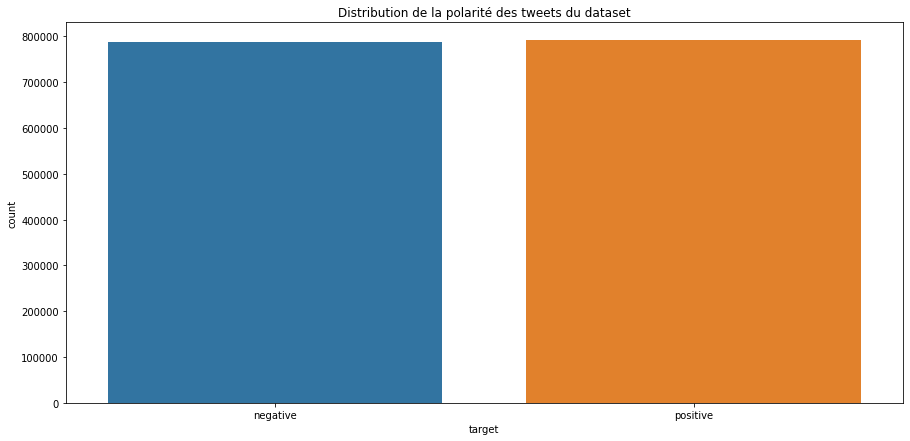

In [24]:
fig = plt.figure(figsize=(15, 7))
sns.barplot(data=df.target.value_counts().reset_index().rename(columns={'target':'count', 'index':'target'}), x='target', y='count')
plt.title("Distribution de la polarité des tweets du dataset")
plt.show()

### Analysons la colonne `ids`

In [25]:
df.ids.duplicated().sum()

0

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Supprimer la colonne `ids` du jeu de données de travail.<br><u>*(action: faite juste en dessous)*</u>

In [26]:
df.drop(columns=['ids'], inplace=True)

In [27]:
display(df.head(2), df.shape)

,target,date,flag,user,text
0,negative,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1579794, 5)

## Analysons la colonne `date`

In [28]:
def parse_tweet_dates(date_time_str):
    return parser.parse(date_time_str,  tzinfos={"PDT": -7*3600})

In [29]:
df['date'] = df.date.apply(parse_tweet_dates)

In [30]:
display(df.head(2), df.shape)

,target,date,flag,user,text
0,negative,2009-04-06 22:19:45-07:00,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,2009-04-06 22:19:49-07:00,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1579794, 5)

#### Regardons les limites de la periode de publication des tweets de notre dataset

In [31]:
df.date.describe(datetime_is_numeric=True)

count                                1579794
mean     2009-05-31 06:53:34.174260992-07:00
min                2009-04-06 22:19:45-07:00
25%                2009-05-28 22:53:24-07:00
50%                2009-06-02 02:56:40-07:00
75%                2009-06-15 05:14:33-07:00
max                2009-06-25 10:28:31-07:00
Name: date, dtype: object

>#### On a donc des tweets dont les dates s'étalent du 06/04/2009 au 25/06/2009
> Il n'y a pas de raison que le lexique utilisé pour qualifier ce qui est *positif* ou *négatif* change en si peu de temps, donc on peut conserver l'ensemble de l'intervalle

#### Regardons à présent la distribution des tweet dans le temps

In [116]:
def plot_bars(data_, title, labels_modulo=1, labels_rotation=90, show_values=True, show_percent=False, x_label=None, y_label=None, **args):
    
    if show_percent:
        total = data_.values.sum()
        data_ = round(data_/total*100.0,2)
        
    fig = plt.figure(figsize=(15, 4))
        
    #with plt.rc_context({
    #    'axes.edgecolor':'orange',
    #    'xtick.color':'orange', 
    #    'ytick.color':'orange', 
    #    'text.color': 'orange',
    #    'axes.labelcolor': 'orange',
        #'figure.facecolor':'orange'
    #}):

    ax = sns.barplot(data=data_, **args)

    if show_values:
        ax.bar_label(ax.containers[0])

    new_ticks = [i.get_text() for i in ax.get_xticklabels()]
    plt.xticks(range(0, len(new_ticks), labels_modulo), new_ticks[::labels_modulo], rotation=labels_rotation)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

    #fig.savefig(f"medias/export.png", transparent=True)

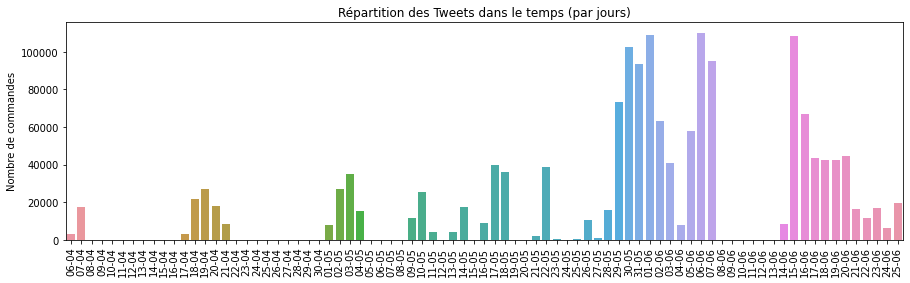

In [33]:
select = df[['date']].copy()
select['short_date'] = select.date.apply(lambda x: x.strftime("%Y-%m-%d"))
#selection['short_date'] = selection.date.apply(lambda x: datetime.strptime(x[4:10] + x[-5:], "%b %d %Y").strftime("%m %d %Y"))
select = pd.DataFrame(select.groupby('short_date').size(), columns=['count'])# .sort_values('short_date')

# add missing dates
idx = pd.date_range('2009-04-06', '2009-06-25')
select.reset_index(inplace=True)
select.index = pd.DatetimeIndex(select['short_date'])
select = select.reindex(idx, fill_value=0)
select = select.drop(columns=['short_date'])
select.index = select.index.strftime('%d-%m')
    
plot_bars(select.T, "Répartition des Tweets dans le temps (par jours)", labels_modulo=1, show_values=False)

>#### On constate que tweets sont inégalement répartis sur notre intervalle de temps
> mais c'est à priori sans conséquence *(selon notre compréhension du jeu de données à ce stade)*

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Supprimer la colonne `date` du jeu de données de travail.<br><u>*(action: faite juste en dessous)*</u>

In [34]:
df.drop(columns=['date'], inplace=True)

In [35]:
display(df.head(2), df.shape)

,target,flag,user,text
0,negative,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1579794, 4)

## Analysons la colonne `flag`

In [36]:
df.flag.value_counts(dropna=False)

NO_QUERY    1579794
Name: flag, dtype: int64

>#### Il n'y a qu'une seule valeur dans cette colonne
> elle ne présente donc aucun intérêt et peut être retirée.

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Supprimer la colonne `flag` du jeu de données de travail.<br><u>*(action: faite juste en dessous)*</u>

In [37]:
df.drop(columns=['flag'], inplace=True)

In [38]:
display(df.head(2), df.shape)

,target,user,text
0,negative,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,scotthamilton,is upset that he can't update his Facebook by ...


(1579794, 3)

## Analysons la colonne `user`

In [39]:
df.user.describe()

count      1579794
unique      653858
top       lost_dog
freq           549
Name: user, dtype: object

>#### On a une répartition inégale du nombre de Tweets par utilisateurs
> mais c'est à priori sans conséquence *(selon notre compréhension du jeu de données à ce stade)*

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Supprimer la colonne `user` du jeu de données de travail.<br><u>*(action: faite juste en dessous)*</u>

In [40]:
df.drop(columns=['user'], inplace=True)

In [41]:
display(df.head(2), df.shape)

,target,text
0,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,is upset that he can't update his Facebook by ...


(1579794, 2)

## Analysons la colonne `text`

In [42]:
df.duplicated(subset=['text']).sum()

0

### Visualisons le jeu de données avant la tokenisation

In [43]:
from wordcloud import WordCloud

In [44]:
from PIL import Image

In [45]:
def plot_wordcloud(text, from_frequency=False, name="wordcloud"):
    mask = np.array(Image.open("medias/twitter.jpg"))
    
    # Create the wordcloud object (the size depends on the mask...)
    wordcloud_export = WordCloud(background_color=None, mode="RGBA", width=1000, height=700, margin=2, collocations=False, random_state=random_seed, mask=mask)
    wordcloud_clean = WordCloud(background_color="White", mode="RGB", width=1000, height=700, margin=2, collocations=False, random_state=random_seed, mask=mask)
    
    if from_frequency:
        wordcloud_export = wordcloud_export.generate_from_frequencies(text)
        wordcloud_clean = wordcloud_clean.generate_from_frequencies(text)
    else:
        wordcloud_export = wordcloud_export.generate(text)
        wordcloud_clean = wordcloud_clean.generate(text)

    # Display the generated image:
    fig = plt.figure(figsize=(15, 10.5))
    plt.imshow(wordcloud_clean, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()
    
    # Export
    wordcloud_export.to_file(f"medias/{name}.png")
    
    #fig.savefig(f"medias/{name}.png", transparent=True)

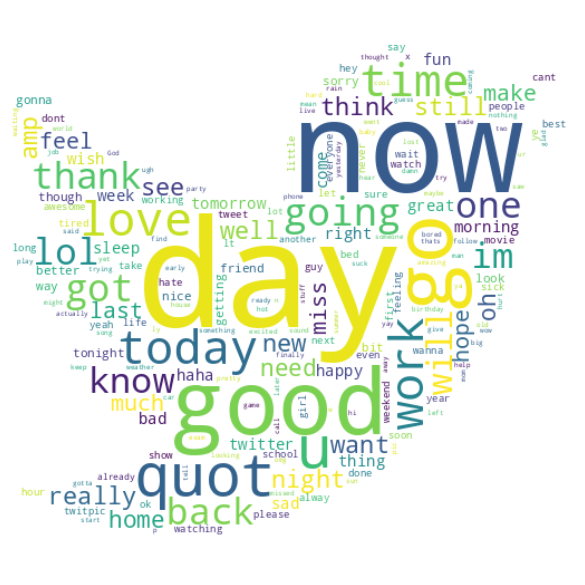

In [46]:
plot_wordcloud(" ".join([x for x in df.text]), name="wordcloud1")

### Étudions la répartition de la taille des tweets *(en nombre de mots et en nombre de caractères)*

In [47]:
def plot_tweet_sizes(data, col_name, x_label, y_label, title1, title2):
    select = pd.DataFrame(data[col_name].value_counts()).reset_index()
    select.sort_values(by='index', inplace=True)
    select.set_index('index', inplace=True)

    size_mean = data[col_name].mean()
    size_median = data[col_name].median()
    max_count = np.array(select).max()

    fig = plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    sns.lineplot(data=select, y=col_name, x='index')
    plt.plot([size_mean, size_mean],[0,max_count], label=f"Moyenne ({size_mean:.2f})", alpha=0.5)
    plt.plot([size_median, size_median],[0,max_count], label=f"Médiane ({size_median:.2f})", alpha=0.5)
    plt.title(title1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    #plt.ylim(0,10000)
    plt.legend()

    select2 = np.cumsum(select)

    plt.subplot(1,2,2)
    sns.lineplot(data=select2, y=col_name, x='index')
    plt.title(title2)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

#### Répartition par nombre de mots

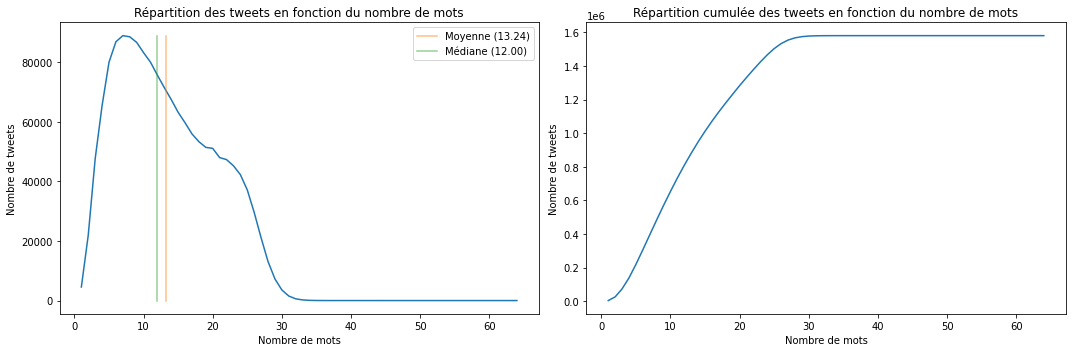

In [48]:
data_tmp = df.copy()
data_tmp['tweet_words'] = df.text.apply(lambda x: len(x.split()))
plot_tweet_sizes(
    data_tmp, 
    col_name = 'tweet_words', 
    title1 = "Répartition des tweets en fonction du nombre de mots",
    title2 = "Répartition cumulée des tweets en fonction du nombre de mots",
    x_label = "Nombre de mots",
    y_label = "Nombre de tweets",
)

#### Répartition par nombre de caractères

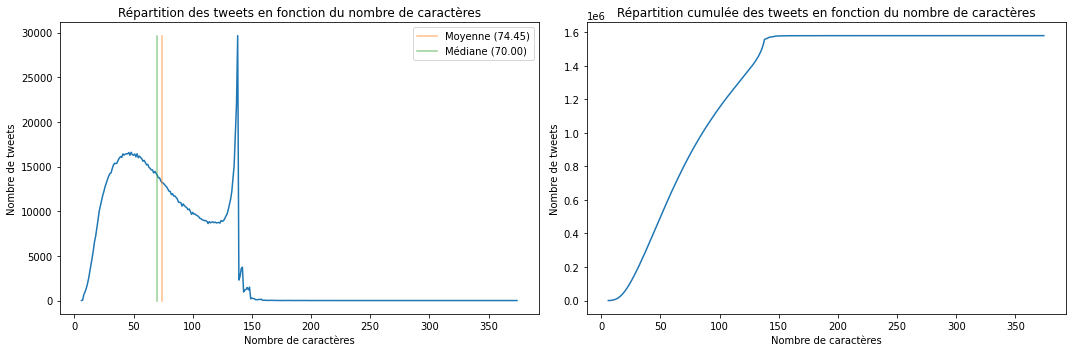

In [49]:
data_tmp['tweet_chars'] = df.text.apply(lambda x: len(x))
plot_tweet_sizes(
    data_tmp, 
    col_name = 'tweet_chars', 
    title1 = "Répartition des tweets en fonction du nombre de caractères",
    title2 = "Répartition cumulée des tweets en fonction du nombre de caractères",
    x_label = "Nombre de caractères",
    y_label = "Nombre de tweets",
)

In [50]:
data_tmp[['tweet_chars', 'tweet_words']].describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_chars,1579794.0,74.452939,36.206900,6.0,44.0,70.0,104.0,374.0
tweet_words,1579794.0,13.241761,6.924276,1.0,7.0,12.0,19.0,64.0


In [51]:
(data_tmp.tweet_chars > 140).sum()

17009

>#### Il se pourrait que l'on ait des outliers à traiter.
> En effet, ef 2009 la limite de caractères des tweets était de 140 or on constate que 17009 dépassent cette limite

### Essayons de comprendre si les échantillons qui dépassent la limite de 140 sont des outliers ou pas

In [52]:
outliers = data_tmp[(data_tmp.tweet_chars > 140)].sort_values('tweet_chars', ascending=False).head()
for outlier in outliers.iterrows():
    print(outlier[1].text, outlier[1].tweet_chars, end='\n\n')

@catfish_ohm à¹à¸à¹à¸²à¹à¸«à¹à¸?à¸²à¸£à¹à¸à¸¹à¸à¸?à¸¸à¹à¸£à¸°(à¸ªà¸±à¸ªà¹+à¸¢à¸¹à¸£à¸´à¹?à¸?à¹à¸à¹à¹?à¸à¸à¸à¸°à¸à¸­à¸à¸µà¸¡à¸´à¹à¸?à¸°à¸«à¸§à¸(à¸à¸à¸²à¸à¹à¸à¸´à¸à¹?à¸?à¸¢à¸±à¸à¹à¸à¸¢à¹à¸«à¹à¹à¸¡à¹à¹à¸à¹à¹à¸«à¸£à¸­.à¹?à¸à¹à¸à¹à¸²à¸à¹à¸«à¸­à¸°à¸£à¸²à¸¢à¸à¸±à¹à¸à¹à¸à¸²à¹à¸¡à¹à¸­à¸°à¸?à¸§à¹à¸²à¸à¸¥à¸²à¹?à¸¡à¸§à¹à¸¢à¸­à¸° =  374

@iannnnn à¹à¸à¸µà¹à¸¢à¸§à¸­à¸µà¸?à¸à¸±à¸?à¸à¸£à¸¹à¹à¸à¸à¹à¸£à¸µà¸¢à¸?à¸à¸µà¸¡ Graphic à¹à¸à¹à¸²à¸¡à¸²à¹?à¸¥à¹à¸§à¸à¸£à¸±à¸à¹à¸¥à¹à¸?à¸à¹à¸­à¸¢à¹à¸«à¹à¸¡à¸±à¸à¸à¸¥à¹à¸²à¸¢à¸?à¸±à¸à¸¢à¸´à¹à¸à¸à¸¶à¹à¸à¸à¸£à¸±à¸ à¹à¸à¸£à¸²à¸°à¸«à¸²à¸?à¹à¸­à¸²à¸¡à¸²à¹à¸à¸µà¸¢à¸à¸?à¸±à¸à¸à¸à¸¡à¸µà¸à¸±à¸?à¸«à¸²à¸­à¸¢à¹à¸²à¸à¸§à¹à¸²à¸à¸£à¸±à¸.  369

5 days till new top gear  î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?

In [53]:
outliers = data_tmp[(data_tmp.tweet_chars > 140)].sort_values('tweet_chars', ascending=True).head()
for outlier in outliers.iterrows():
    print(outlier[1].text, outlier[1].tweet_chars, end='\n\n')

Tuesdayï¿½ll start with reflection ï¿½n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers  141

@tickedypoph my ex BF a virgo &amp; SO particular! but clever - so i know you'll think up some gold. have a great swim! it's 11 degrees here  141

@pocketedward vocÃª compreende inglÃªs ? que mara ! how much is any twilight doll ? donÂ´t have in brasil  xoxo , uma pessoa brasileira HAHA! 141

@ihackinjosh beejive &amp; 2 more app will be out with their push versions soon. But all of them mention that we will need MobileMe account.  141

i hate how i want to type more than the allowed amount of words, finding myself trying to shorten my words to bad punctuation &amp; spelling  141



>#### On constate que d'étranges séquences ce caractères apparaissent dans les tweets qui dépassent la limite de 140.
> - pourtant le jeu de données utilisé stipule que c'est un jeu de données sans emoticons.
> - il se pourrait donc que ce soit des tweets rédigés dans une autre langues ; **caractères syllabiques**
> - ou encore des **codes html**

### Convertisons les caractères écrits avec des entitées html *(&amp, &quote, etc.)*

In [54]:
from bs4 import BeautifulSoup

In [55]:
df['text'] = df.text.apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

/home/valkea/Dev/OpenClassrooms/Projets_AI/P7/venvP7/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


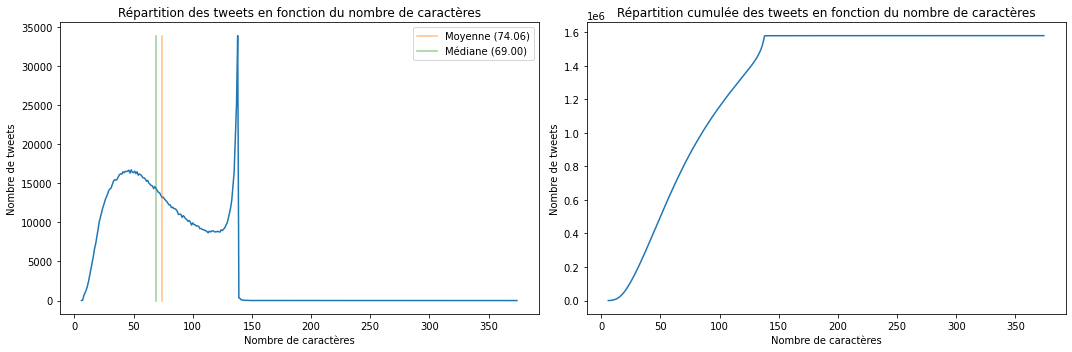

In [56]:
data_tmp = df.copy()
data_tmp['tweet_chars'] = df.text.apply(lambda x: len(x))
plot_tweet_sizes(
    data_tmp, 
    col_name = 'tweet_chars', 
    title1 = "Répartition des tweets en fonction du nombre de caractères",
    title2 = "Répartition cumulée des tweets en fonction du nombre de caractères",
    x_label = "Nombre de caractères",
    y_label = "Nombre de tweets",
)

In [57]:
(data_tmp.tweet_chars > 140).sum()

685

In [58]:
outliers = data_tmp[(data_tmp.tweet_chars > 140)].sort_values('tweet_chars', ascending=False).head(5)
for outlier in outliers.iterrows():
    print(outlier[1].text, outlier[1].tweet_chars, end='\n\n')

@catfish_ohm à¹à¸à¹à¸²à¹à¸«à¹à¸?à¸²à¸£à¹à¸à¸¹à¸à¸?à¸¸à¹à¸£à¸°(à¸ªà¸±à¸ªà¹+à¸¢à¸¹à¸£à¸´à¹?à¸?à¹à¸à¹à¹?à¸à¸à¸à¸°à¸à¸­à¸à¸µà¸¡à¸´à¹à¸?à¸°à¸«à¸§à¸(à¸à¸à¸²à¸à¹à¸à¸´à¸à¹?à¸?à¸¢à¸±à¸à¹à¸à¸¢à¹à¸«à¹à¹à¸¡à¹à¹à¸à¹à¹à¸«à¸£à¸­.à¹?à¸à¹à¸à¹à¸²à¸à¹à¸«à¸­à¸°à¸£à¸²à¸¢à¸à¸±à¹à¸à¹à¸à¸²à¹à¸¡à¹à¸­à¸°à¸?à¸§à¹à¸²à¸à¸¥à¸²à¹?à¸¡à¸§à¹à¸¢à¸­à¸° =  374

@iannnnn à¹à¸à¸µà¹à¸¢à¸§à¸­à¸µà¸?à¸à¸±à¸?à¸à¸£à¸¹à¹à¸à¸à¹à¸£à¸µà¸¢à¸?à¸à¸µà¸¡ Graphic à¹à¸à¹à¸²à¸¡à¸²à¹?à¸¥à¹à¸§à¸à¸£à¸±à¸à¹à¸¥à¹à¸?à¸à¹à¸­à¸¢à¹à¸«à¹à¸¡à¸±à¸à¸à¸¥à¹à¸²à¸¢à¸?à¸±à¸à¸¢à¸´à¹à¸à¸à¸¶à¹à¸à¸à¸£à¸±à¸ à¹à¸à¸£à¸²à¸°à¸«à¸²à¸?à¹à¸­à¸²à¸¡à¸²à¹à¸à¸µà¸¢à¸à¸?à¸±à¸à¸à¸à¸¡à¸µà¸à¸±à¸?à¸«à¸²à¸­à¸¢à¹à¸²à¸à¸§à¹à¸²à¸à¸£à¸±à¸.  369

5 days till new top gear  î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?

In [59]:
outliers = data_tmp[(data_tmp.tweet_chars > 140)].sort_values('tweet_chars', ascending=True).head(5)
for outlier in outliers.iterrows():
    print(outlier[1].text, outlier[1].tweet_chars, end='\n\n')

Tuesdayï¿½ll start with reflection ï¿½n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers  141

@Nimatime ï£« BlackberryÂ® I actually applied but they said I had 2 move 2 canada 4 the position I wanted  kinda sad... I$H Crackberry addict 141

Yup - loyalfam4life: Â Welllâ¦. looks like â¦.. NO ONE CARES!!!! HAHAHAHAHA i hate my life  Â U love ur life... http://tumblr.com/xwg222cl2 141

on est Ã  La RÃ©union! we're at RÃ©union Island  woOOoo awesome weather, island is beautiful, loads of fun with Pioneer Unit and African  ... 141

n-n-nicky... - n-n-nicky: Iï¿½ll be seventeen in about 2 weeks. cool  i didnï¿½t want to seem nosey lol, but i... http://tumblr.com/xxq1whsju 141



>#### Malgré le décodage des entitées HTML
> on constate la présence d'encodage UTF-8 non convertis : e.g. Ã© qui devrait être la lettre "é"


In [60]:
def encode_spe(x):
    try:
        return x.encode('latin1').decode('utf-8')
    except Exception:
        return x
    
df['text'] = df.text.apply(encode_spe)

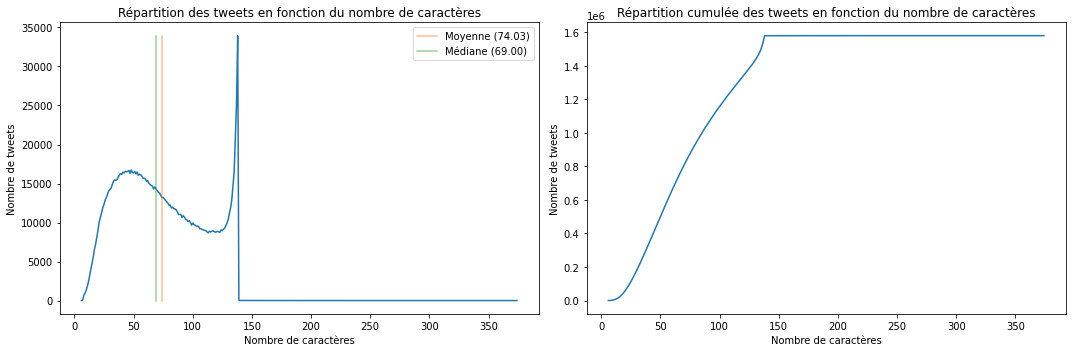

In [61]:
data_tmp['tweet_chars'] = df.text.apply(lambda x: len(x))
plot_tweet_sizes(
    data_tmp, 
    col_name = 'tweet_chars', 
    title1 = "Répartition des tweets en fonction du nombre de caractères",
    title2 = "Répartition cumulée des tweets en fonction du nombre de caractères",
    x_label = "Nombre de caractères",
    y_label = "Nombre de tweets",
)

In [62]:
(data_tmp.tweet_chars > 140).sum()

391

In [63]:
outliers = data_tmp[(data_tmp.tweet_chars > 140)].sort_values('tweet_chars', ascending=False).head(5)
for outlier in outliers.iterrows():
    print(outlier[1].text, outlier[1].tweet_chars, end='\n\n')

@catfish_ohm à¹à¸à¹à¸²à¹à¸«à¹à¸?à¸²à¸£à¹à¸à¸¹à¸à¸?à¸¸à¹à¸£à¸°(à¸ªà¸±à¸ªà¹+à¸¢à¸¹à¸£à¸´à¹?à¸?à¹à¸à¹à¹?à¸à¸à¸à¸°à¸à¸­à¸à¸µà¸¡à¸´à¹à¸?à¸°à¸«à¸§à¸(à¸à¸à¸²à¸à¹à¸à¸´à¸à¹?à¸?à¸¢à¸±à¸à¹à¸à¸¢à¹à¸«à¹à¹à¸¡à¹à¹à¸à¹à¹à¸«à¸£à¸­.à¹?à¸à¹à¸à¹à¸²à¸à¹à¸«à¸­à¸°à¸£à¸²à¸¢à¸à¸±à¹à¸à¹à¸à¸²à¹à¸¡à¹à¸­à¸°à¸?à¸§à¹à¸²à¸à¸¥à¸²à¹?à¸¡à¸§à¹à¸¢à¸­à¸° =  374

@iannnnn à¹à¸à¸µà¹à¸¢à¸§à¸­à¸µà¸?à¸à¸±à¸?à¸à¸£à¸¹à¹à¸à¸à¹à¸£à¸µà¸¢à¸?à¸à¸µà¸¡ Graphic à¹à¸à¹à¸²à¸¡à¸²à¹?à¸¥à¹à¸§à¸à¸£à¸±à¸à¹à¸¥à¹à¸?à¸à¹à¸­à¸¢à¹à¸«à¹à¸¡à¸±à¸à¸à¸¥à¹à¸²à¸¢à¸?à¸±à¸à¸¢à¸´à¹à¸à¸à¸¶à¹à¸à¸à¸£à¸±à¸ à¹à¸à¸£à¸²à¸°à¸«à¸²à¸?à¹à¸­à¸²à¸¡à¸²à¹à¸à¸µà¸¢à¸à¸?à¸±à¸à¸à¸à¸¡à¸µà¸à¸±à¸?à¸«à¸²à¸­à¸¢à¹à¸²à¸à¸§à¹à¸²à¸à¸£à¸±à¸.  369

5 days till new top gear  î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?

In [64]:
outliers = data_tmp[(data_tmp.tweet_chars > 140)].sort_values('tweet_chars', ascending=True).head(5)
for outlier in outliers.iterrows():
    print(outlier[1].text, outlier[1].tweet_chars, end='\n\n')

Ã?ron, NÃ³ri, me and others are heading right now to the commemoration of the speech Viktor OrbÃ¡n delivered 20 years ago, on 16th June 1989  141

@tridento Ð½Ðµ Ð¼Ð¾Ñ  Broadcom Corporation NetXtreme BCM5764M Gigabit Ethernet PCIe (rev 10) - Ð¾Ð½Ð¾ Ñ? firmware Ð² Ð»Ñ?Ð»ÑÐºÑ?Ðµ Ð´Ð°Ð¶Ðµ 141

@moodeey @mohalfares Ø§Ù ÙØ§ÙÙÙ ÙØ³ÙØª Ø§ÙÙÙØ¹Ø¯ ÙØ¹ Ø§ÙÙ ÙÙØª ÙØ³Ø¬ÙÙØ§ Ù?Ù ØªÙÙ?ÙÙÙ ÙÙÙ Ø§ØºÙÙ Ø¨Ø¯ÙÙ Ø´Ø­Ù  141

@usako_minamino hehe cÃ¡i miroticon ss ko xem ÄÃ¢u, fáº£i chá»«a Äá» má»t Äc táº­n máº¯t xem chá»©  ss Äag rÃ¡g kiá»?m lÃ²g Äai... =.= 141

@GreatRock Guess Iâll be using my own bike at the Stop Crashing day as I dont think a 18â? bike would really fit me. Never mind next time  141



# On a un problème avec l'encodage

---

>#### On constate que :
> - la moitié des reviews ont moins de 12 "mots"
> - aucun des 1.579.794 tweets ont 0 "mot"... 
> - 4544 des 1.579.794 tweets ont 1 "mot"...

---
>#### `TODO`  done ✅ | todo ❌ |
> - ❌ Faut-il supprimer les tweets de 1 mot
> - ❌ Faut-il supprimer les outliers *(plus de 28 mots / 0.99 quantiles ?)*. Ils risquent d'utiliser des mots non réprésentatifs.
<br><u>*~~(action: fait ci-dessous)~~*</u>

In [66]:
data_tmp.tweet_chars.quantile(0.99)

138.0

In [67]:
(data_tmp.tweet_chars > 140).sum()

391

# TODO
Voir si la création de nouvelles colonnes apporte quelque chose au modèle
- nombre de mots
- nombre de caractères
- nombre moyens de mots / caractères ?
- nombre de stopwords
- nombre de #hastags
- nombre de @mentions
- nombre de nombres/chiffres
- nombre d'emails
- nombre de majuscules

---

## 3.1 Tokenization <a class="anchor" id="tokenize"></a> [⇪](#menu)
>#### Nous allons profiter de cette étape de tokenisation pour supprimer:
> - les majuscules,
> - les espaces en début et fin de texte.

In [68]:
!python -m spacy download en_core_web_sm -qq
#!python -m spacy download en_core_web_md -qq
nlp = spacy.load('en_core_web_sm')

2022-07-22 10:13:50.355023: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-22 10:13:50.355063: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [69]:
nlp.add_pipe("language_detector")

In [70]:
def tokenize(text):

    # suppression des majuscules
    text = text.lower()

    # suppression des espaces au début et à la fin des textes
    text = text.strip()

    # tokenisation
    return nlp(text)

In [71]:
display(df.head(2), df.shape)

,target,text
0,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,is upset that he can't update his Facebook by ...


(1579794, 2)

### Préparons les Tokens *(ou chargeons les si ils ont déjà été sauvegardés)*

In [72]:
def save_tokens(data, path):
    #doc_bin = DocBin(attrs=["LEMMA", "ENT_IOB", "ENT_TYPE"], store_user_data=True)
    doc_bin = DocBin(store_user_data=True)
    data.apply(lambda x: doc_bin.add(x))
    bytes_data = doc_bin.to_bytes()
    
    with open(path, "wb") as binary_file:
        binary_file.write(bytes_data)
        
def load_tokens(path):
    with open(path, "rb") as binary_file:
        bytes_data = binary_file.read()
        
    nlp = spacy.blank("en")
    doc_bin = DocBin().from_bytes(bytes_data)
    docs = list(doc_bin.get_docs(nlp.vocab))
    
    return docs

In [73]:
df_origin = df.copy()
df = df_origin.sample(10000)

In [84]:
if(os.path.exists(TOKENS_PATH) and LOAD_TOKENS_FROM_FILE==True):
    print(f"LOADING Tokens from '{TOKENS_PATH}'")
    df['tokens'] = load_tokens(TOKENS_PATH)
else:
    print(f"PREPARING Tokens")
    df['tokens'] = df.text.apply(tokenize)
    print(f"SAVING Tokens tp '{TOKENS_PATH}'")
    save_tokens(df['tokens'], TOKENS_PATH)

LOADING Tokens from 'data/tokens.bin'


In [85]:
display(df.head(2), df.shape)

,target,text,tokens
1305473,positive,@mitchelmusso has the OSSUM-est album ever. If...,"(@mitchelmusso, has, the, ossum, -, est, album..."
171789,negative,Wating to get my hair cut before prom. It suck...,"(wating, to, get, my, hair, cut, before, prom,..."


(10000, 3)

## 3.2 Filtrage des tokens <a class="anchor" id="filter"></a> [⇪](#menu)

>#### Nous allons profiter de cette étape pour supprimer:
> - ~~les majuscules~~ *(fait lors de la tokenization)*,
> - ~~les espaces en début et fin de texte.~~ *(fait lors de la tokenization)*,
> - tout ce qui n'est pas détecté comme étant de l'anglais *(language & language_score)*,
> - la ponctuation *(PUNCT)*,
> - les stop-words *(is_stop)*,
> - les espaces *(SPACE)*,
> - les chiffres *(is_alpha)*,
> - mais aussi les beaucoup d'autres tags peu utiles dans ce cas *(ADV, AUX, CONJ, CCONJ, DET, PART, PRON, PROPN, SCONJ, SYM)*.
>
>#### Par ailleurs on va utiliser les **lemmes** *(raçines contextualisées)* des mots pour rassembler ceux qui sont assez similaires.

> pos_ tag ist
>
> - `ADJ`: adjective, e.g. big, old, green, incomprehensible, first
> - `ADP`: adposition, e.g. in, to, during
> - `ADV`: adverb, e.g. very, tomorrow, down, where, there
> - `AUX`: auxiliary, e.g. is, has (done), will (do), should (do)
> - `CONJ`: conjunction, e.g. and, or, but
> - `CCONJ`: coordinating conjunction, e.g. and, or, but
> - `DET`: determiner, e.g. a, an, the
> - `INTJ`: interjection, e.g. psst, ouch, bravo, hello
> - `NOUN`: noun, e.g. girl, cat, tree, air, beauty
> - `NUM`: numeral, e.g. 1, 2017, one, seventy-seven, IV, MMXIV
> - `PART`: particle, e.g. ’s, not,
> - `PRON`: pronoun, e.g I, you, he, she, myself, themselves, somebody
> - `PROPN`: proper noun, e.g. Mary, John, London, NATO, HBO
> - `PUNCT`: punctuation, e.g. ., (, ), ?
> - `SCONJ`: subordinating conjunction, e.g. if, while, that
> - `SYM`: symbol, e.g. $, %, §, ©, +, −, ×, ÷, =, :), 😝
> - `VERB`: verb, e.g. run, runs, running, eat, ate, eating
> - `X`: other, e.g. sfpksdpsxmsa
> - `SPACE`: space, e.g. 

In [86]:
def filter_tokens(doc, except_words = []):

    # suppression des majuscules
    # text = text_.lower()

    # suppression des espaces au début et à la fin des textes
    #text = text.strip()

    # tokenisation
    # doc = nlp(text)
    # spacy.displacy.render(doc, style='dep',jupyter=True)
    
    # suppression des stopwords, de la ponctuation, des espaces et des adverbes et de ce qui n'est pas en anglais
    tokens = [token for token in doc 
              if not token.is_stop 
              # and doc._.language == 'en'
              # and doc._.language_score > 0.7
              # and not token.is_punct
              # and not token.is_space 
              # and not token.is_digit 
              and token.is_alpha
              and token.pos_ not in ['ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SPACE', 'SYM'] 
              and token.lemma_ not in except_words
             ]
        
    return tokens if len(tokens) > 1 else "FILTERED"

#### Regardons si il y a des textes dans d'autres langues ou dans de l'anglais approximatif ou argotique

In [87]:
i = 0
for doc in df.tokens:
    # is in english
    if doc._.language != 'en':
        print("NOT ENGLISH:\n", doc, "\n", "-"*50)
        i += 1
    elif doc._.language_score <= 0.7:
        print(f"GIBBERISH:{doc._.language_score}\n", doc, "\n", "-"*50)
        i += 1
        
    if i == 20:
        break

GIBBERISH:0.6673808097839355
 @donniewahlberg i remember the news about it 
 --------------------------------------------------
NOT ENGLISH:
 im back from myh uk trip 
 --------------------------------------------------
GIBBERISH:0.5630218386650085
 @sanasaleem thanks 
 --------------------------------------------------
GIBBERISH:0.565453052520752
 soooo sad im sleeping alone.  i miss my bear. 
 --------------------------------------------------
NOT ENGLISH:
 i am proud of you! 
 --------------------------------------------------
GIBBERISH:0.26091626286506653
 @shotgunreload your gay 
 --------------------------------------------------
GIBBERISH:0.6165978908538818
 @mrspinkyivory aww pinky i hope everything works out 4 
 --------------------------------------------------
NOT ENGLISH:
 about to check out tha space  no im not addicted 
 --------------------------------------------------
NOT ENGLISH:
 @patleeart oh .. me2 
 --------------------------------------------------
GIBBERISH:0.54

---
>#### `TODO`  done ✅ | todo ❌ |

In [88]:
df['tokens'] = df.tokens.apply(filter_tokens)

## 3.3 Lemmatization des tokens <a class="anchor" id="lemmatize"></a> [⇪](#menu)

In [90]:
def lemmatize(doc):
    return [token.lemma_ for token in doc if type(token) != str]

#### Lemmatisons les tokens

In [91]:
df['lemmas'] = df.tokens.apply(lemmatize)
display(df.head(2), df.shape)

,target,text,tokens,lemmas
1305473,positive,@mitchelmusso has the OSSUM-est album ever. If...,"[ossum, est, album, bought, congrats, mitch, w...","[ossum, est, album, buy, congrat, mitch, wait,..."
171789,negative,Wating to get my hair cut before prom. It suck...,"[wating, hair, cut, prom, sucks, people, screa...","[wating, hair, cut, prom, suck, people, scream..."


(10000, 4)

#### Regardons si ils ont tous des lemmes...

In [92]:
df[df['lemmas'].str.len() == 0].shape

(810, 4)

In [93]:
df[df['lemmas'].str.len() == 0]

,target,text,tokens,lemmas
1546279,positive,@sara_ @camy_san thank you so much,FILTERED,[]
1459118,positive,@sanasaleem Thanks,FILTERED,[]
1541492,positive,going to see up.,FILTERED,[]
1504133,positive,I am proud of you!,FILTERED,[]
359665,negative,@smueller94 why not though ??,FILTERED,[]
...,...,...,...,...
282631,negative,@msibathadiva nothing much. You need to take m...,FILTERED,[]
642499,negative,@Hicksdesign,FILTERED,[]
420745,negative,"@piiyaahn oh, Really??",FILTERED,[]
192021,negative,@SammySamLA are you serious about @djever,FILTERED,[]


#### Supprimons ces quelques phrases *(ça évitera des problèmes plus tard avec les mesures de cohérence c_v par exemple)* 

In [94]:
df = df[df.tokens != 'FILTERED']
display(df.head(2), df.shape)

,target,text,tokens,lemmas
1305473,positive,@mitchelmusso has the OSSUM-est album ever. If...,"[ossum, est, album, bought, congrats, mitch, w...","[ossum, est, album, buy, congrat, mitch, wait,..."
171789,negative,Wating to get my hair cut before prom. It suck...,"[wating, hair, cut, prom, sucks, people, screa...","[wating, hair, cut, prom, suck, people, scream..."


(9190, 4)

#### Visualisons le jeu de données après la tokenisation

In [95]:
def get_all_lemmas(data):
    all_lemmas = []
    for tokens in data:
        all_lemmas.extend(tokens)
    return all_lemmas

all_lemmas = get_all_lemmas(df.lemmas)

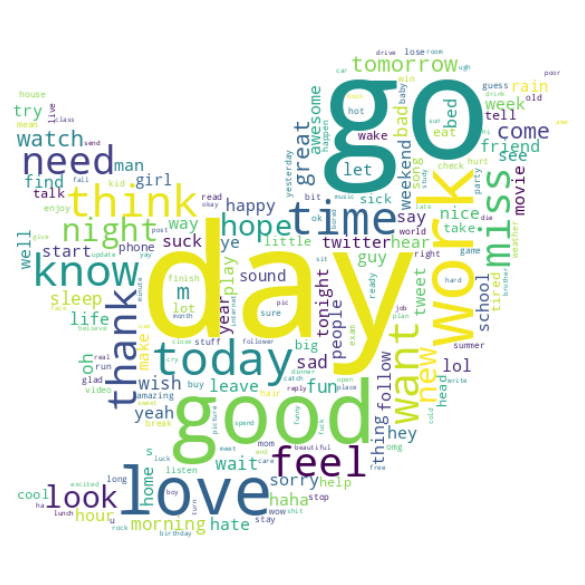

In [96]:
plot_wordcloud(" ".join(all_lemmas), name="wordcloud2")

---
>#### `TODO`  done ✅ | todo ❌ |

## 3.4 Suppression des mots les plus fréquents <a class="anchor" id="most_frequents"></a> [⇪](#menu)

In [113]:
lemmas_freq = Counter(all_lemmas)
common_lemmas = lemmas_freq.most_common(100)
print (common_lemmas)

[('day', 708), ('go', 667), ('good', 652), ('get', 568), ('work', 486), ('love', 484), ('like', 465), ('today', 453), ('time', 425), ('think', 391), ('know', 390), ('want', 363), ('miss', 337), ('feel', 320), ('thank', 319), ('need', 278), ('night', 270), ('look', 257), ('hope', 231), ('tomorrow', 230), ('watch', 229), ('great', 227), ('new', 223), ('come', 220), ('m', 218), ('morning', 218), ('bad', 214), ('oh', 212), ('wish', 211), ('sleep', 199), ('fun', 199), ('sad', 193), ('wait', 190), ('happy', 178), ('try', 178), ('sorry', 174), ('week', 170), ('twitter', 162), ('leave', 161), ('friend', 161), ('lol', 161), ('tonight', 160), ('way', 153), ('haha', 148), ('bed', 148), ('thing', 146), ('yeah', 143), ('find', 140), ('nice', 140), ('yes', 138), ('start', 133), ('play', 132), ('say', 131), ('people', 130), ('hour', 127), ('life', 123), ('school', 122), ('tweet', 121), ('see', 120), ('weekend', 119), ('awesome', 118), ('hate', 116), ('guy', 115), ('have', 114), ('movie', 114), ('foll

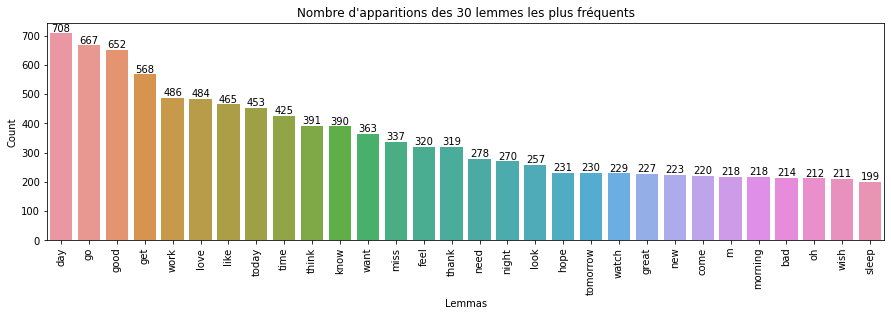

In [117]:
select = pd.DataFrame(common_lemmas[:30], columns=['lemmas','count'])
plot_bars(select, title="Nombre d'apparitions des 30 lemmes les plus fréquents", x='lemmas', y='count', show_values=True, y_label="Count", x_label="Lemmas")

## 3.5 Création du Dictionnaire <a class="anchor" id="dict"></a> [⇪](#menu)

Pour les modèles que nous allons essayer, il nous faut un **Dictionnaire** et un **Corpus**.
- Le Dictionnaire permet d'associer un ID unique à chaque token.
- Le `Corpus - Bag Of Word` contient une liste (un pour chaque document) de *term vectors* qui indiquent la fréquence de chaque mot du *vocabulaire*.
- Le `Corpus - TF-IDF` est une version *normalisée* du précédent pour éviter que des mots sans importance mais fréquents prennent trop d'importance.

In [118]:
from gensim.corpora.dictionary import Dictionary

In [119]:
dictionary = Dictionary(df['lemmas'])

In [120]:
print(str(dictionary.token2id)[:1000], "... }")

{'album': 0, 'buy': 1, 'concert': 2, 'congrat': 3, 'est': 4, 'mitch': 5, 'ossum': 6, 'u': 7, 'wait': 8, 'cut': 9, 'go': 10, 'hair': 11, 'hour': 12, 'people': 13, 'prom': 14, 'scream': 15, 'suck': 16, 'talk': 17, 'wate': 18, 'wating': 19, 'dammit': 20, 'food': 21, 'give': 22, 'like': 23, 'poisoning': 24, 'think': 25, 'throw': 26, 'time': 27, 'hope': 28, 'okay': 29, 'week': 30, 'leave': 31, 'want': 32, 'duh': 33, 'good': 34, 'know': 35, 'luck': 36, 'oh': 37, 'wonder': 38, 'new': 39, 'photoshoot': 40, 'tire': 41, 'b': 42, 'guy': 43, 'mad': 44, 'showcase': 45, 'song': 46, 'news': 47, 'remember': 48, 'ammo': 49, 'away': 50, 'boo': 51, 'bummed': 52, 'd': 53, 'happy': 54, 'have': 55, 'ju': 56, 'm': 57, 'rush': 58, 'trip': 59, 'disconnect': 60, 'fly': 61, 'launch': 62, 'leak': 63, 'month': 64, 'quick': 65, 'satellite': 66, 'shuttle': 67, 'history': 68, 'sadness': 69, 'snippet': 70, 'treasure': 71, 'tv': 72, 'feel': 73, 'hard': 74, 'human': 75, 'person': 76, 'realization': 77, 'turn': 78, 'itun

In [121]:
len(dictionary)

8589

#### Supprimons les mots les plus fréquents et les moins fréquents
- On supprime les mots qui apparaissent dans moins de 5 documents
- On supprime les mots qui apparaissent dans plus de 50% des documents

In [122]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=None)

In [123]:
len(dictionary)

1419

#### Récupérons la Fréquence de chaque lemme pour afficher à nouveau le WordCloud

In [124]:
dico_df = pd.DataFrame(dictionary.items(), columns=['index', 'key']).set_index('index')

In [125]:
values = [[x[0], x[1]] for x in dictionary.cfs.items()]

In [126]:
count_df = pd.DataFrame(values, columns=['index','count']).set_index('index').sort_values('index')

In [127]:
TF = count_df.merge(dico_df, on='index', how='left').set_index('key')

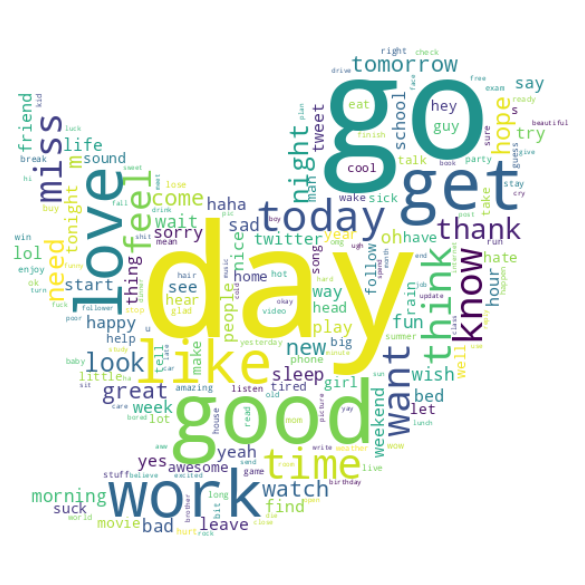

In [128]:
plot_wordcloud(TF.to_dict()['count'], from_frequency=True, name="wordcloud3")

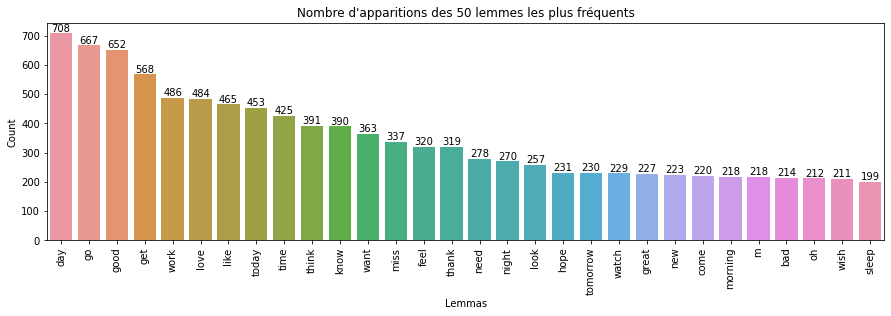

In [129]:
plot_bars(TF.sort_values('count', ascending=False)[:30].T, title="Nombre d'apparitions des 50 lemmes les plus fréquents", show_values=True, y_label="Count", x_label="Lemmas")

## XXX Split du dataset

In [179]:
from sklearn.preprocessing import LabelEncoder

In [180]:
label_encoder = LabelEncoder()

In [183]:
targets = label_encoder.fit_transform(df.target)

In [154]:
from sklearn.model_selection import train_test_split

In [239]:
df_train_full, df_test, y_train_full, y_test = train_test_split(df.lemmas, targets, test_size=0.2)

In [240]:
df_train, df_valid, y_train, y_valid = train_test_split(df_train_full, y_train_full, test_size=df_test.shape[0])

In [242]:
df_train_full.shape, df_train.shape, df_valid.shape, df_test.shape, y_train_full.shape, y_train.shape, y_valid.shape, y_test.shape

((7352,), (5514,), (1838,), (1838,), (7352,), (5514,), (1838,), (1838,))

## 3.6 Création du Corpus Bag-Of-Words <a class="anchor" id="corpus_bow"></a> [⇪](#menu)

Le `Corpus - Bag Of Word` contient une liste (un pour chaque document) de *term vectors* qui indiquent la fréquence de chaque mot du *vocabulaire*.

In [245]:
corpus_train = [" ".join(x) for x in df_train]
len(corpus_train)

5514

In [246]:
corpus_test = [" ".join(x) for x in df_test]
len(corpus_test)

1838

## 3.7 Création du Corpus TF-IDF <a class="anchor" id="corpus_tfidf"></a> [⇪](#menu)
Le `Corpus - TF-IDF` est une version *normalisée* du Bag-Of-Words pour éviter que des mots sans importance mais fréquents prennent trop d'importance.

In [248]:
tfidf_vectorizer_train = TfidfVectorizer(use_idf=True, min_df=5, max_df=0.5)
X_train = tfidf_vectorizer_train.fit_transform(corpus_train)
display(tfidf_vectorizer_train.get_feature_names_out())
print(X_train.shape)

array(['able', 'access', 'accident', 'account', 'ache', 'act', 'ad',
       'add', 'afternoon', 'age', 'agree', 'ah', 'ahh', 'air', 'airport',
       'alarm', 'album', 'allow', 'alot', 'alright', 'amazing',
       'american', 'angel', 'animal', 'anniversary', 'annoying', 'answer',
       'app', 'apple', 'appreciate', 'arm', 'arrive', 'art', 'article',
       'ask', 'asleep', 'ass', 'atm', 'attack', 'attempt', 'attention',
       'available', 'aw', 'awake', 'award', 'awesome', 'aww', 'babe',
       'baby', 'background', 'bad', 'bag', 'ball', 'band', 'bank', 'bar',
       'bday', 'be', 'beach', 'bear', 'beat', 'beautiful', 'bed', 'beer',
       'begin', 'believe', 'bet', 'bf', 'big', 'bike', 'bill', 'birthday',
       'bit', 'bitch', 'black', 'blackberry', 'blame', 'blast', 'bless',
       'block', 'blog', 'bloody', 'blow', 'blue', 'board', 'body', 'boo',
       'book', 'boot', 'bore', 'bored', 'boring', 'borrow', 'bother',
       'bottle', 'bout', 'box', 'boy', 'boyfriend', 'bread', 'br

(5514, 962)


In [249]:
#tfidf_vectorizer_test = TfidfVectorizer(use_idf=True, min_df=5, max_df=0.5)
X_test = tfidf_vectorizer_train.transform(corpus_test)
display(tfidf_vectorizer_test.get_feature_names_out()[:20], "...")
print(X_test.shape)

array(['able', 'add', 'ah', 'allow', 'alright', 'amazing', 'arrive',
       'ask', 'ass', 'awake', 'award', 'awesome', 'aww', 'baby', 'bad',
       'bank', 'beach', 'bear', 'beat', 'beautiful'], dtype=object)

'...'

(1838, 962)


---
---
# 4. Classification<a class="anchor" id="classification"></a> [⇪](#menu)

In [293]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, f1_score, average_precision_score
from collections import defaultdict

In [294]:
def print_classification_report(y_true, y_pred):
    """ Display a classification report based on the provided lists
        
    Parameters
    ----------
    y_true: list
        the expected values
    y_pred: list
        the predicted values
    """
        
    report = classification_report(y_true, y_pred, labels=[0,1], target_names=['Prediction = 0', 'Prediction = 1'], zero_division=0)
    print("--- Classification Report ---".ljust(100,'-'),"\n\n", report)

In [295]:
def print_confusion_matrix(y_true, y_pred):
    """ Display a confusion matrix based on the provided lists
        
    Parameters
    ----------
    y_true: list
        the expected values
    y_pred: list
        the predicted values
    """
    
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    print("--- Confusion Matrix ---".ljust(100,'-'),"\n")
    plt.show()

In [296]:
def print_rocauc(y_true, y_pred_dict, figsize=[5,5], ax=None, top_others=3):
    """ Display the 'top_others' best ROC Curves + the last provided ROC Curve
        
    Parameters
    ----------
    y_true: list
        the expected values
    y_pred_dict: list
        the predicted values for several models
    """
    
    print(f"--- ROC AUC ---".ljust(100,'-'),"\n")
    auc_scores = {}
    #last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt
        
    # find top scores:
    last_score_name = list(y_pred_dict)[-1]
    sorted_scores = defaultdict(list)
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        if model_name != last_score_name:
            roc_score = roc_auc_score(y_true, y_pred)
            sorted_scores[model_name] = roc_score
    sorted_scores = sorted(sorted_scores, key=lambda x:sorted_scores[x], reverse=True)[:top_others]
    sorted_scores.append(last_score_name)
    
    # display
    #for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
    for i, model_name in enumerate(sorted_scores):
        alpha_v = 1 if i == min(top_others, len(sorted_scores)-1) else 0.2
        
        y_pred = y_pred_dict[model_name]
        roc_score = roc_auc_score(y_true, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        
        ax.plot(fpr, tpr, label=f"{model_name} ({roc_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = roc_score
            
    ax.plot([0, 1], [0, 1], label='Random (0.5)', linestyle='--', color='red', alpha=0.5)
    plt.xlabel('FPR (Positive label: 1)')
    plt.ylabel('TPR (Positive label: 1)')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return auc_scores

In [297]:
from sklearn.metrics import precision_recall_curve

def print_prauc(y_true, y_pred_dict, figsize=[5,5], ax=None, top_others=3):
    """ Display the 'top_others' best Precision Recall Curves + the last provided Precision Recall Curve
        
    Parameters
    ----------
    y_true: list
        the expected values
    y_pred_dict: list
        the predicted values for several models
    """
    
    print(f"--- PRECISION RECALL AUC ---".ljust(100,'-'), "\n")
    auc_scores = {}
    #last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt
        
    # find top scores:
    last_score_name = list(y_pred_dict)[-1]
    sorted_scores = defaultdict(list)
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        if model_name != last_score_name:
            pr_score = average_precision_score(y_true, y_pred)
            sorted_scores[model_name] = pr_score
    sorted_scores = sorted(sorted_scores, key=lambda x:sorted_scores[x], reverse=True)[:top_others]
    sorted_scores.append(last_score_name)

    # display
    #for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
    for i, model_name in enumerate(sorted_scores):
        alpha_v = 1 if i == min(top_others, len(sorted_scores)-1) else 0.2
        
        y_pred = y_pred_dict[model_name]
        pr_score = average_precision_score(y_true, y_pred)
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
        
        ax.plot(recall, precision, label=f"{model_name} ({pr_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = pr_score
        
    no_skill = len(y_true[y_true==1]) / len(y_true)            
    ax.plot([0, 1], [no_skill, no_skill], label='No skill', linestyle='--', color='red', alpha=0.3)
    ax.plot([1, 0], [0, 1], label='Balanced', linestyle='--', color='green', alpha=0.5)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return auc_scores

In [298]:
def save_score(method_name, threshold, param_grid, training_time, inference_time, **scores):
    """ Save the scores into the 'scores_df' DataFrame and to the 'scores_path' CSV file.
    Each call to this function appends exactly one row to the DataFrame and hence to the CSV.
        
    Parameters
    ----------
    method_name: str
        the name used to identify the record in the list
    threshold: float
        the threshold used to get the provided scores
    param_grid: dict
        the parameter grid used to get the provided scores
    training_time: float
        the time needed for the fitting process
    inference_time: float
        the time needed for the prediction process
    scores: list of parameters
        the scores to register
    """
    
    idx = np.where(scores_df.Method == method_name)[0]        
    idx = idx[0] if idx.size > 0 else len(scores_df.index)
    
    rocauc_value = scores.get('roc_auc', None)
    f1_value =  scores.get('f1', None)
    accuracy_value =  scores.get('accuracy', None)
    precision_value =  scores.get('precision', None)
    recall_value = scores.get('recall', None)
    prauc_value = scores.get('average_precision', None)
    TP = scores.get('TP', None)
    FP = scores.get('FP', None)
    TN = scores.get('TN', None)
    FN = scores.get('FN', None)
    
    scores_df.loc[idx] = [method_name, threshold, param_grid, rocauc_value, prauc_value, f1_value, accuracy_value, precision_value, recall_value, TP, TN, FP, FN, training_time, inference_time]    
    scores_df.to_csv(scores_path, index=False)

In [299]:
scores_df = pd.DataFrame(columns=['Method', 'threshold', 'params', 'ROC AUC', 'PR AUC', 'F1 score', 'Accuracy', 'Precision', 'Recall', 'TP', 'TN', 'FP', 'FN', 'Training time', 'Inference time'])
y_preds = {}
scores_path = 'data/scores.csv'
scores_df.to_csv(scores_path, index=False)

def get_scores(method_name, model, X_ref=None, y_ref=None, param_grid=None, threshold=None, training_time=None, inference_time=None, register=False, simple=False, show_classification=True, show_confusion=True, show_roccurves=True, **scores):
    """ Compute / Display / Save scores for the provided model
    
    More precisely, it compute the scores then call various function to display and save them.
        
    Parameters
    ----------
    method_name: str
        the name used to identify the record in the list
    model: 
        the model that needs to be evaluated
    X_ref: list of lists
        the X values used to get the predictions
    y_ref: list
        the expected values
    param_grid: dict
        the parameter grid used to get the provided scores
    training_time: float
        the time needed for the fitting process
    inference_time: float
        the time needed for the prediction process
    scores: list of parameters
        the scores to register
    """
    
    if X_ref is None:
        X_ref = X_test
        
    if y_ref is None:
        y_ref = y_test
    
    y_pred, y_pred_proba, inference_time = predict(model, X_ref, threshold)
    cm = confusion_matrix(y_ref, y_pred, labels=[0,1])

    scores = {
        'roc_auc': roc_auc_score(y_ref, y_pred_proba),
        'f1': f1_score(y_ref, y_pred),
        'accuracy': accuracy_score(y_ref, y_pred),
        'precision': precision_score(y_ref, y_pred, zero_division=0),
        'recall': recall_score(y_ref, y_pred),
        'average_precision': average_precision_score(y_ref, y_pred_proba),
        'TN': cm[0][0],
        'FP': cm[0][1],
        'FN': cm[1][0],
        'TP': cm[1][1],
    }
    
    # Register score and replace if it already exists
    if register:
        save_score(method_name, threshold, param_grid, training_time, inference_time, **scores)
    
    # Basic report
    scores_str = ""
    for key in scores.keys():
        if type(scores[key]) == np.float64 and key not in ['TP','TN','FP','FN']:
            scores_str += f"{key.upper().rjust(20)} : {scores[key]:.4f}\n"
            
    print('-'*100,f'These information are based on the best estimator of the above cross-validation'.center(100,), '-'*100, sep='\n', end='\n\n')
    print(f"--- {method_name} ---".ljust(100,'-'),"\n\n",scores_str, sep="")
          
    if simple:
        return
    
    # Classification report
    if show_classification:
        print_classification_report(y_ref, y_pred)
    
    # Confusion Matrix
    if show_confusion:
        print_confusion_matrix(y_ref, y_pred)
    
    # ROC AUC curves
    if show_roccurves:
        y_preds[method_name] = y_pred_proba
        print_rocauc(y_ref, y_preds)
        print_prauc(y_ref, y_preds)

In [300]:
def predict(model, X_ref, threshold=None):
    """ Convenience function that generalize the prediction process
        
    Parameters
    ----------
    model: 
        the model that needs to make predictions
    X_ref: list of lists
        the X values used to get the predictions
    threshold: float (None)
        the threshold used to get the provided scores
        
    Returns
    -------
    list
        the binary predictions
    list
        the probabilities
    float
        the time needed for the prediction process
    """
    
    t0 = time.perf_counter()
    
    y_pred_proba = model.predict_proba(X_ref)[:,1]
    if threshold:
        y_pred = get_labels_from_threshold(y_pred_proba, threshold)
    else:
        y_pred = model.predict(X_ref)
    
    tt = time.perf_counter() - t0
    return y_pred, y_pred_proba, tt

In [301]:
def get_labels_from_threshold(y_proba, threshold):
    """ Convenience function that quickly convert proabilities to binary results
        
    Parameters
    ----------
    y_proba: list
        the list of probabilities
    threshold: float (None)
        the threshold used to make the choices
        
    Returns
    -------
    list
        the binary predictions
    """
    
    return (y_proba >= threshold).astype('int')


def find_best_threshold(model, X_valid, y_valid, eval_function ):
    """ Find the threshold that maximize the provided scoring function
        
    Parameters
    ----------
    model: 
        the model that needs to make predictions
    X_valid: list of lists
        the X values used to get the predictions
    y_valid: list
        the expected values
    eval_function: function
        the scoring method used to find the best threshold
        
    Returns
    -------
    float
        the best score found for the provided metric
    float
        the threshold matching the best metric's score
    """
    
    best_threshold = 0.0
    best_score = 0.0
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    
    for threshold in np.arange(0, 1, 0.001):
        
        y_pred_threshold = get_labels_from_threshold(y_pred_proba, threshold)
        
        score = eval_function(y_valid, y_pred_threshold)
        if score >= best_score:
            best_threshold = threshold
            best_score = score
        
    return best_score, best_threshold

In [302]:
from sklearn.experimental import enable_halving_search_cv
#from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV  # --> ne supporte pas le multi-scoring
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # --> GridSearchCV trop lent


def fit_model(model, X_ref=None, y_ref=None, param_grid = {}, scoring='roc_auc', cv=5, verbose=2, register=True):
    """ Search the best hyper-parameters for the provided model
        
    Parameters
    ----------
    model: 
        the model that needs to make predictions
    X_ref: list of lists
        the X values used to get the predictions
    y_ref: list
        the expected values
    param_grid: dict
        the parameter grid used to get the provided scores
    scoring: str
        the scoring method to use when evaluating the model in the Grid Search CV process
    cv: int / CrossValidation
        the number of cross validations to apply OR the instance of a CrossValidation instance
    verbose: int
        defines how much details are printed while training the model
        0 : nothing
        1 : K-fold scores + results for test set
        2 : K-fold scores + results for test & train sets
        
    Returns
    -------
    dict
        a dictionnary containing:
        - grid: the grid search instance 
        - model: the grid search best estimator
        - training_time: the fitting time
        - inference_time: the prediction time
        - param_grid: the parameters used for the grid search
    """
    
    if X_ref is None:
        X_ref = X_train
        
    if y_ref is None:
        y_ref = y_train
        
    fit_time = time.perf_counter()
    grid_model = RandomizedSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, random_state=random_seed, refit=scoring)
    #grid_model = HalvingRandomSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, min_resources=500, random_state=random_seed)
    #grid_model = HalvingGridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, min_resources=500, random_state=random_seed)
    #grid_model = GridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, refit="roc_auc", return_train_score=True)
    grid_model.fit(X_ref, y_ref)
    fit_time = time.perf_counter() - fit_time

    results = grid_model.cv_results_
    n_splits = cv.n_splits if hasattr(cv, 'n_splits') else cv
    sets_list = ["test"] if verbose < 3 else ["train", "test"]
    
    # Print K-fold scores
    if verbose > 1:
        for i in range(n_splits):
            print(f"".center(100,'-'))
        
            for sample in sets_list:
                scores_str = f"{scoring.upper()}: {results[f'split{i}_{sample}_score'].mean():.4f}"
                print(f"FOLD-{i+1} {sample.upper().rjust(6)} scores | {scores_str}")
                
    # Print overall scores
    if verbose > 0:
   
        for sample in sets_list:
            print('\n', f" {sample.upper()}-CV-SPLIT MEAN SCORES ".center(100,'-'), sep='')
            mean_str = f"{scoring.upper()}: {results[f'mean_{sample}_score'].mean():.4f} (std:{results[f'std_{sample}_score'].mean():.4f})"
            print(f"\n- {mean_str}")
            
        print("\n", f"".center(100,'-'), sep='')
    
    inf_time = pd.Series(grid_model.cv_results_['mean_score_time']).mean()
    
    return {'grid':grid_model, 'model':grid_model.best_estimator_, 'training_time':fit_time, 'inference_time':inf_time, 'param_grid':param_grid} #, **scores_args}

#### Let's define the cross-validation method

In [303]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

## 1. Établissons une base-line avec un algorithm naïf *(Dummy Classifier)* <a class="anchor" id="models_dummy"></a> [⇪](#menu)

In [304]:
from sklearn.dummy import DummyClassifier
import time

In [305]:
model_name = "DummyClassifier"

In [320]:
grd_dummy = fit_model( 
    DummyClassifier(),
    param_grid={ 'random_state':[random_seed], 'strategy':['stratified'] }, 
    cv = skfold,
    verbose=2,
    X_ref = X_train,
    y_ref = y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5275
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5239
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.4931
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5031
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.4981

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5091 (std:0.0140)

----------------------------------------------------------------------------------------------------


/home/valkea/Dev/OpenClassrooms/Projets_AI/P7/venvP7/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic LogisticRegression -----------------------------------------------------------------------

             ROC_AUC : 0.5147
                  F1 : 0.5168
            ACCURACY : 0.5147
           PRECISION : 0.5157
              RECALL : 0.5179
   AVERAGE_PRECISION : 0.5086

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.51      0.51      0.51       917
Prediction = 1       0.52      0.52      0.52       921

      accuracy                           0.51      1838
     macro avg       0.51      0.51      0.51      1838
  weighted avg       0.51  

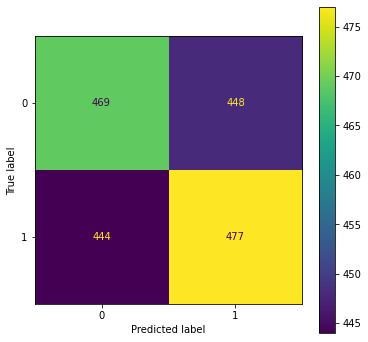

--- ROC AUC ---------------------------------------------------------------------------------------- 



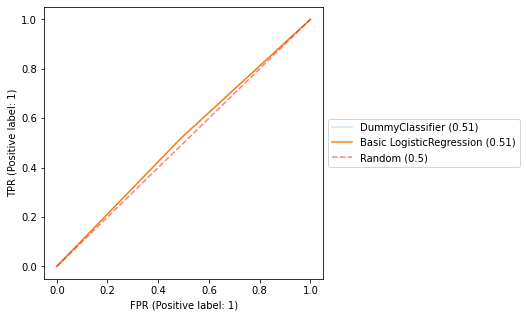

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



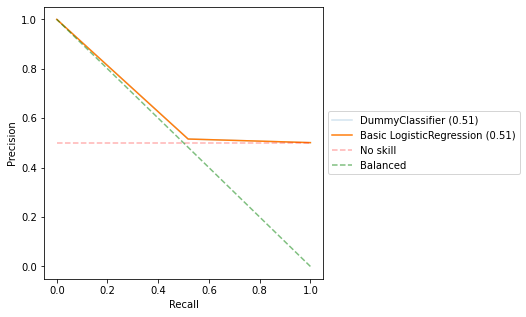

In [321]:
get_scores(model_name, **grd_dummy, register=True, X_ref=X_test, y_ref=y_test)

In [322]:
del grd_dummy

## 2. Essayons un algorithme linéaire - Logistic Regression <a class="anchor" id="models_linear"></a> [⇪](#menu)

In [323]:
from sklearn.linear_model import LogisticRegression

In [324]:
from scipy.stats import uniform, loguniform

In [325]:
param_grid = [
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['saga'],
        'penalty' : ['elasticnet'], # none
        'C' : loguniform(1e-5, 1e2),
        'l1_ratio' : uniform(0,1)
    },
]

In [326]:
model_name = "Basic LogisticRegression"
max_lr_iter = 3000

grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref = X_train,
    y_ref = y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6863
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6835
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6633
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6402
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6527

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6652 (std:0.0181)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic LogisticRegression -----------------------------------------------------------------------

             ROC_AUC : 0.7751
                  F1 : 0.7131
            ACCURACY : 0.7089
           PRECISION : 0.7044
              RECALL : 0.7220
   AVERAGE_PRECISION : 0.7618

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.71      0.70      0.70       917
Prediction = 1       0.70      0.72      0.71       921

      accuracy                           0.71      1838
     macro avg       0.71      0.71      0.71      1838
  weighted avg       0.71  

/home/valkea/Dev/OpenClassrooms/Projets_AI/P7/venvP7/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


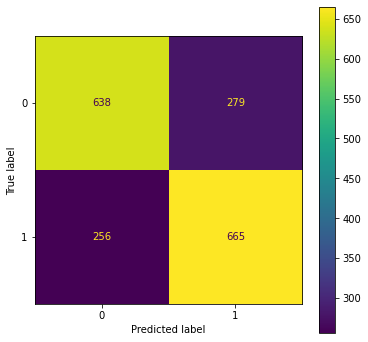

--- ROC AUC ---------------------------------------------------------------------------------------- 



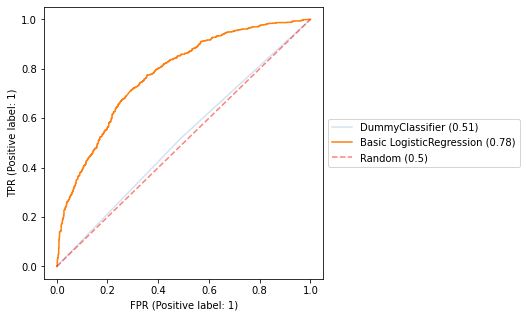

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



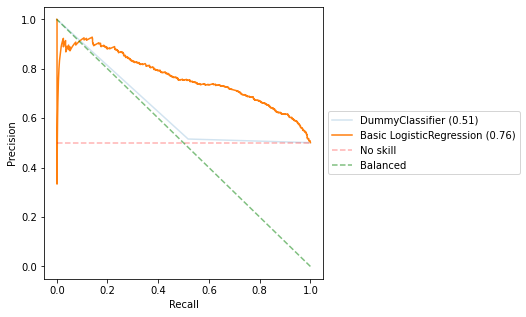

In [327]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test, y_ref=y_test)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [47]:
del grd_log